Importing basic libraries

In [2]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

Importing libraries for image augmentation

In [3]:
import warnings
warnings.filterwarnings('ignore')
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian

# from torchsummary import summary
import pandas as pd
from skimage.io import imread, imsave
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy import ndimage

Import libraries for CNNs

In [4]:
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

Helper functions

In [5]:
# Helper functions

def load_image(infilename):
    data = io.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

Loading a set of images

In [6]:
root_dir = "data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images, size of the training dataset
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

n = 20 # Use 20 images for training

Loading 20 images
Loading 20 images


Data Augmentation

Size of augmented training images : 100
Size of augmented training ground truth images : 100


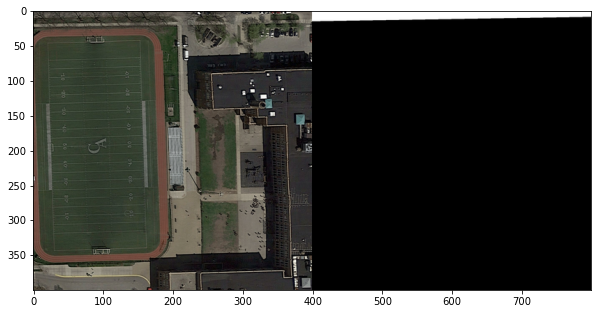

In [16]:
final_imgs = []
final_gt_imgs = []
for i in range(len(imgs)):
    # standard images
    final_imgs.append(imgs[i])
    final_gt_imgs.append(gt_imgs[i])
    # rotated images
    final_imgs.append(rotate(imgs[i], angle=45, mode = 'wrap'))
    final_gt_imgs.append(rotate(gt_imgs[i], angle=45, mode = 'wrap'))
    # images flipped from left to right
    final_imgs.append(np.fliplr(imgs[i]))
    final_gt_imgs.append(np.fliplr(gt_imgs[i]))
    # images flipped up-down
    final_imgs.append(np.flipud(imgs[i]))
    final_gt_imgs.append(np.flipud(gt_imgs[i]))
    # images with random noise added : does not change the classification on ground truth images
    final_imgs.append(random_noise(imgs[i],var=0.2**2))
    final_gt_imgs.append(gt_imgs[i])

print("Size of augmented training images : " + str(len(final_imgs)))
print("Size of augmented training ground truth images : " + str(len(final_gt_imgs)))

cimg = concatenate_images(final_imgs[50], final_gt_imgs[50])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

Visualizing augmented images

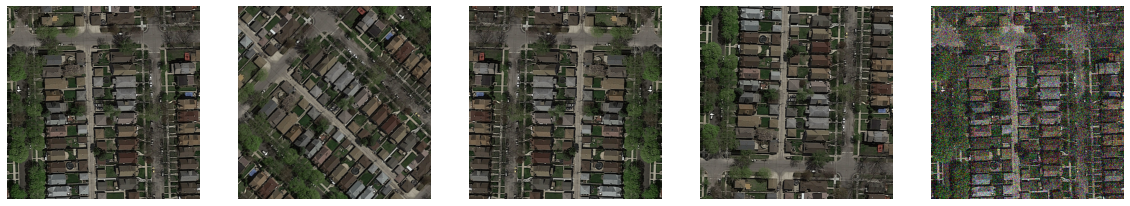

In [18]:
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(20,20))
for i in range(5):
    ax[i].imshow(final_imgs[i+30])
    ax[i].axis('off')

Extract patches from input images

In [19]:
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(final_imgs[i], patch_size, patch_size) for i in range(len(final_imgs))]
gt_patches = [img_crop(final_gt_imgs[i], patch_size, patch_size) for i in range(len(final_gt_imgs))]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

Extract 6-dimensional features consisting of average RGB color as well as variance

In [20]:
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    return X

Compute features for each patch

In [21]:
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

print(X.shape)
print(Y.shape)

(62500, 2)
(62500,)


Print feature stats

In [22]:
print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))  #TODO: fix, length(unique(Y)) 

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 62500 features
Feature dimension = 2
Number of classes = 1
Class 0: 44524 samples
Class 1: 17976 samples


Training with logistic regression and soft SVM

In [23]:
from sklearn import linear_model, svm

# we create an instance of the classifier and fit the data
# logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
# logreg.fit(X, Y)

# fit the model with SVM NuSVC
soft_svm = svm.NuSVC(gamma="auto")
soft_svm.fit(X, Y)

# fit the model with SVM SVC
# soft_svm_2 = svm.SVC(gamma="auto")
#soft_svm_2.fit(X, Y)

NuSVC(gamma='auto')

In [24]:
# Predict on the training set - comment the lines you do not want to perform
#################################################
# COMMENT OR UNCOMMENT Z TO TRY ALL METHODS
#################################################
# Z = logreg.predict(X) # logistic regression
Z = soft_svm.decision_function(X)    # soft SVM NuSVC
# Z = soft_svm_2.decision_function(X)    # soft SVM SVC

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
print('True positive rate = ' + str(TPR))   # 0.287616 for augmented soft SVM

Converting dataset to PyTorch format

In [ ]:
# TODO

Defining the architecture (CNN)

In [ ]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(32),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
            # Defining another 2D convolution layer
            Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(64),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
            # Defining another 2D convolution layer
            Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(128),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
            # Defining another 2D convolution layer
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(128),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
        )

        self.linear_layers = Sequential(
            Linear(128 * 14 * 14, 512),
            ReLU(inplace=True),
            Dropout(),
            Linear(512, 256),
            ReLU(inplace=True),
            Dropout(),
            Linear(256,10),
            ReLU(inplace=True),
            Dropout(),
            Linear(10,2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Defining hyperparameters

In [ ]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.000075)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

Training phase

In [ ]:
torch.manual_seed(0)

# batch size of the model
batch_size = 64
# number of epochs to train the model
n_epochs = 20
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    permutation = torch.randperm(final_imgs.size()[0])
    training_loss = []
    for i in tqdm(range(0,final_imgs.size()[0], batch_size)):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = final_imgs[indices], final_gt_imgs[indices]
        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs,batch_y)
        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    training_loss = np.average(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss)